<a href="https://colab.research.google.com/github/AdityaKRaj/Pytorch/blob/main/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode 1/15, Federated Aggregation Completed
Episode 2/15, Federated Aggregation Completed
Episode 3/15, Federated Aggregation Completed
Episode 4/15, Federated Aggregation Completed
Episode 5/15, Federated Aggregation Completed
Episode 6/15, Federated Aggregation Completed
Episode 7/15, Federated Aggregation Completed
Episode 8/15, Federated Aggregation Completed
Episode 9/15, Federated Aggregation Completed
Episode 10/15, Federated Aggregation Completed
Episode 11/15, Federated Aggregation Completed
Episode 12/15, Federated Aggregation Completed
Episode 13/15, Federated Aggregation Completed
Episode 14/15, Federated Aggregation Completed
Episode 15/15, Federated Aggregation Completed
Average Collision Rate with Random Policy: 0.0
Average Cumulative Reward with Random Policy: 7613.586037242407
Average Collision Rate with Trained Agents: 1.6
Average Cumulative Reward with Trained Agents: 12312.400572665667


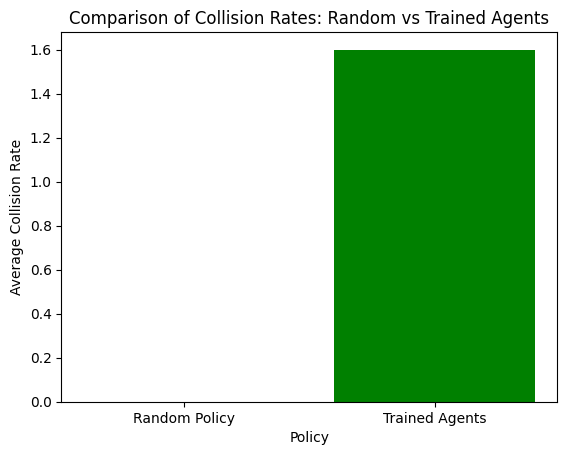

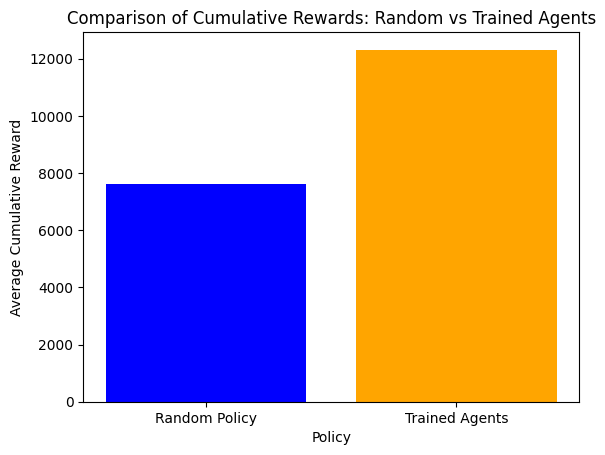

In [6]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os


# Load Data
cab_ids = []
with open('/content/cab_id.txt', 'r') as file:
    for line in file:
        if 'cab id' in line:
            cab_id = line.split('"')[1]
            cab_ids.append(cab_id)


columns = ['latitude', 'longitude', 'occupancy', 'timestamp']
cabspot_data = []


for cab_id in cab_ids:
    cab_file_path = f'/content/new_{cab_id}.txt'
    if os.path.exists(cab_file_path):
        cab_df = pd.read_csv(cab_file_path, delimiter=' ', names=columns)
        cab_df['cab_id'] = cab_id
        cabspot_data.append(cab_df)


if cabspot_data:
    cabspot_df = pd.concat(cabspot_data, ignore_index=True)
else:
    raise ValueError("No cab data loaded. Ensure that the dataset files are correctly uploaded.")


cabspot_df['timestamp'] = pd.to_datetime(cabspot_df['timestamp'], unit='s')
cabspot_df['latitude'] = cabspot_df['latitude'].round(3)
cabspot_df['longitude'] = cabspot_df['longitude'].round(3)






class OptimizedTrafficEnvironment:
    def __init__(self, cabspot_df, grid_size=0.01, collision_radius=.01, max_steps=100):
        self.cabspot_df = cabspot_df
        self.grid_size = grid_size
        self.agents = cabspot_df['cab_id'].unique()
        self.positions = {}
        self.collision_radius = collision_radius
        self.max_steps = max_steps
        self.steps = 0


        # Initialize goal positions (drop-off points) and high-demand areas (pick-up points)
        self.goal_positions = {agent: self._get_random_goal_position() for agent in self.agents}
        self.high_demand_areas = {agent: self._get_random_high_demand_area() for agent in self.agents}


    def reset(self):
        self.steps = 0
        for agent in self.agents:
            random_row = self.cabspot_df[self.cabspot_df['cab_id'] == agent].sample()
            grid_x = (random_row['latitude'].values[0] // self.grid_size).astype(int)
            grid_y = (random_row['longitude'].values[0] // self.grid_size).astype(int)
            self.positions[agent] = (grid_x, grid_y, random_row['occupancy'].values[0])


        # Reset goal and demand areas for each agent
        self.goal_positions = {agent: self._get_random_goal_position() for agent in self.agents}
        self.high_demand_areas = {agent: self._get_random_high_demand_area() for agent in self.agents}


    def _get_random_goal_position(self):

        random_row = self.cabspot_df.sample()  # Randomly select a row from the dataset
        grid_x = (random_row['latitude'].values[0] // self.grid_size).astype(int)
        grid_y = (random_row['longitude'].values[0] // self.grid_size).astype(int)
        return grid_x, grid_y


    def _get_random_high_demand_area(self):

      random_row = self.cabspot_df.sample()  # Randomly select a row from the dataset
      grid_x = (random_row['latitude'].values[0] // self.grid_size).astype(int)
      grid_y = (random_row['longitude'].values[0] // self.grid_size).astype(int)
      return grid_x, grid_y




    def step(self, actions):
        rewards = {}
        next_positions = {}
        steps_without_collision = 0


        # Move agents and calculate penalties for staying idle
        for agent, action in actions.items():
            current_pos = self.positions[agent]
            next_pos, penalty = self._take_action(current_pos, action)
            next_positions[agent] = next_pos
            rewards[agent] = penalty  # Reward for taking action, includes penalty for staying


        # Check for collisions
        collisions = set()
        for agent, next_pos in next_positions.items():
            collision = False
            for other_agent, other_pos in next_positions.items():
                if agent != other_agent:
                    if self._check_collision(next_pos, other_pos):
                        collision = True
                        collisions.add(agent)
                        collisions.add(other_agent)


            if collision:
                rewards[agent] = -10  # Penalty for collision
                # print(f"Collision detected for agent: {agent} at {next_pos}")
            else:
                rewards[agent] += self._get_reward(next_pos, steps_without_collision, self.goal_positions[agent], self.high_demand_areas[agent])


        self.positions = next_positions
        self.steps += 1


        done = self.steps >= self.max_steps
        return self.positions, rewards, done


    def _take_action(self, position, action):
        actions_map = {
            0: (0, self.grid_size),  # North
            1: (0, -self.grid_size),  # South
            2: (self.grid_size, 0),  # East
            3: (-self.grid_size, 0),  # West
            4: (0, 0)  # Stay (penalty for staying idle)
        }


        grid_x, grid_y, occupancy = position
        move = actions_map[action]


        if action == 4:
            return (grid_x, grid_y, occupancy), -5  # Penalty for staying idle


        return (grid_x + move[0], grid_y + move[1], occupancy), 0


    def _check_collision(self, pos1, pos2):
        dist_x = abs(pos1[0] - pos2[0])
        dist_y = abs(pos1[1] - pos2[1])
        return dist_x <= self.collision_radius and dist_y <= self.collision_radius


    def _get_reward(self, position, steps_without_collision, goal_position, high_demand_area):
        # Distance to goal and demand area
        dist_to_goal = np.sqrt((position[0] - goal_position[0])**2 + (position[1] - goal_position[1])**2)
        dist_to_demand = np.sqrt((position[0] - high_demand_area[0])**2 + (position[1] - high_demand_area[1])**2)


        # Reward for moving toward the goal (closer to drop-off point)
        if dist_to_goal < 5:
            reward = 20 - dist_to_goal  # Higher reward as agent gets closer
        else:
            reward = 5 - dist_to_goal


        # Reward decay based on steps taken
        reward -= steps_without_collision * 0.05


        # Reward for being near high-demand areas (if free)
        if position[2] == 0 and dist_to_demand < 5:
            reward += 10 - dist_to_demand  # Reward for being near high-demand areas when free


        return reward




# DQN Agent implementation
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.05  # Allow more exploration
        self.epsilon_decay = 0.995  # Slow down the decay for more exploration
        self.learning_rate = 0.001
        self.model = self._build_model()


    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])


    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.state_size,)),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model


# Federated Server
class FederatedServer:
    def __init__(self, agents):
        self.agents = agents


    def aggregate_weights(self):
        new_weights = [np.zeros_like(weight) for weight in self.agents[0].model.get_weights()]
        for agent in self.agents:
            agent_weights = agent.model.get_weights()
            for i in range(len(new_weights)):
                new_weights[i] += agent_weights[i]
        for i in range(len(new_weights)):
            new_weights[i] /= len(self.agents)
        return new_weights


    def distribute_weights(self, new_weights):
        for agent in self.agents:
            agent.model.set_weights(new_weights)


# Federated Training Function
def federated_train(environment, agents, server, episodes=10):
    max_time_steps = 200


    for e in range(episodes):
        environment.reset()
        states = [np.reshape(environment.positions[agent], [1, 3]) for agent in environment.agents]


        for time in range(max_time_steps):
            actions = {agent: agents[i].act(states[i]) for i, agent in enumerate(environment.agents)}
            next_positions, rewards, done = environment.step(actions)


            states = [np.reshape(next_positions[agent], [1, 3]) for agent in environment.agents]


            if done:
                break


        new_weights = server.aggregate_weights()
        server.distribute_weights(new_weights)
        print(f"Episode {e + 1}/{episodes}, Federated Aggregation Completed")






# print(cabspot_df.head())


env = OptimizedTrafficEnvironment(cabspot_df)
agents = [DQNAgent(state_size=3, action_size=5) for _ in range(len(env.agents))]
server = FederatedServer(agents)


federated_train(env, agents, server, episodes=15)


# Evaluation Function
def evaluate_agents(environment, agents, policy="trained", episodes=10, max_time_steps=200):
    collision_counts = []
    cumulative_rewards = []


    for e in range(episodes):
        environment.reset()
        total_collision_count = 0
        total_cumulative_reward = 0


        for time in range(max_time_steps):
            actions = {}


            if policy == "random":
                actions = {agent: random.randint(0, 4) for agent in environment.agents}
            elif policy == "trained":
                states = [np.reshape(environment.positions[agent], [1, 3]) for agent in environment.agents]
                actions = {agent: agents[i].act(states[i]) for i, agent in enumerate(environment.agents)}


            _, rewards, _ = environment.step(actions)


            total_collision_count += sum(1 for reward in rewards.values() if reward == -10)
            total_cumulative_reward += sum(rewards.values())


        collision_counts.append(total_collision_count)
        cumulative_rewards.append(total_cumulative_reward)


    avg_collision_rate = sum(collision_counts) / len(collision_counts)
    avg_cumulative_reward = sum(cumulative_rewards) / len(cumulative_rewards)


    return avg_collision_rate, avg_cumulative_reward




random_collision_rate, random_cumulative_reward = evaluate_agents(env, agents, policy="random", episodes=10)
trained_collision_rate, trained_cumulative_reward = evaluate_agents(env, agents, policy="trained", episodes=10)


print(f"Average Collision Rate with Random Policy: {random_collision_rate}")
print(f"Average Cumulative Reward with Random Policy: {random_cumulative_reward}")
print(f"Average Collision Rate with Trained Agents: {trained_collision_rate}")
print(f"Average Cumulative Reward with Trained Agents: {trained_cumulative_reward}")


# Plot Comparison
labels = ['Random Policy', 'Trained Agents']
collision_rates = [random_collision_rate, trained_collision_rate]
cumulative_rewards = [random_cumulative_reward, trained_cumulative_reward]


# Plot Collision Rates
plt.bar(labels, collision_rates, color=['red', 'green'])
plt.xlabel('Policy')
plt.ylabel('Average Collision Rate')
plt.title('Comparison of Collision Rates: Random vs Trained Agents')
plt.show()


# Plot Cumulative Rewards
plt.bar(labels, cumulative_rewards, color=['blue', 'orange'])
plt.xlabel('Policy')
plt.ylabel('Average Cumulative Reward')
plt.title('Comparison of Cumulative Rewards: Random vs Trained Agents')
plt.show()






